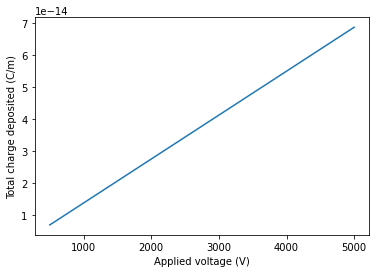

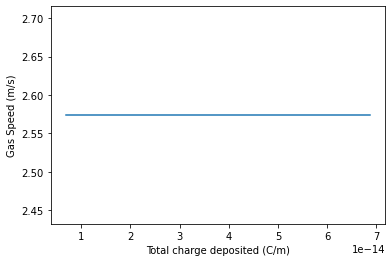

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

# Simulation parameters
f = 10000  # Frequency (Hz)
E_rms = np.linspace(500, 5000, 10) / (np.sqrt(2) * np.pi * 0.1)  # Root mean square electric field (V/m)
L = 1  # Length of discharge (m)
d = 0.1  # Distance between electrodes (m)
W = 0.1  # Width of electrodes (m)
A = L * W  # Surface area of electrodes (m^2)
mu_0 = 4 * np.pi * 10**(-7)  # Permeability of free space (H/m)
epsilon_0 = 8.854 * 10**(-12)  # Permittivity of free space (F/m)
epsilon_r = 4  # Relative permittivity of dielectric material
sigma = 10**(-5)  # Conductivity of dielectric material (S/m)
ec = 1.6e-19 # Elementary charge (C)
na=1.e21  #

# Constants for kinetic reactions
T_e = 1.5  # Electron temperature (eV)
T_g = 300  # Gas temperature (K)
m_e = 9.11e-31  # Electron mass (kg)
m_g = 28 * 1.66e-27  # Molecular nitrogen mass (kg)
h = 6.626e-34  # Planck's constant (J s)
k_B = 1.38e-23  # Boltzmann's constant (J/K)
nu_ion = 1e15 * np.exp(-15.6 / T_e)  # Ionization rate coefficient (m^3/s)
nu_exc = 5.5e9 * np.exp(-11.7 / T_e)  # Excitation rate coefficient (m^3/s)
nu_att = 2.3e-14 * (300 / T_e)**0.7  # Attachment rate coefficient (m^3/s)

def ionization_rate(T_e):
    """
    Calculates the electron-ionization rate coefficient as a function of electron temperature.
    """
    E_ion = 15.6  # Ionization energy of nitrogen (eV)
    alpha = 1.6e-19 * np.sqrt(E_ion / (2 * np.pi * m_e)) / h**3
    return alpha * (T_e / E_ion)**0.5 * np.exp(-E_ion / T_e)

def excitation_rate(T_e):
    """
    Calculates the electron-excitation rate coefficient as a function of electron temperature.
    """
    E_exc = 11.7  # Excitation energy of nitrogen (eV)
    alpha = 8.5e-20 * np.sqrt(E_exc / (2 * np.pi * m_e)) / h**3
    return alpha * np.exp(-E_exc / T_e)

def attachment_rate(T_e):
    """
    Calculates the electron-attachment rate coefficient as a function of electron temperature.
    """
    alpha = 4.4e-31 * np.sqrt(T_e) / m_g**0.5
    beta = 1.8e-17 * (T_e / 300)**(-0.7)
    return alpha + beta

Q_total = []
v_gas = []

for E in E_rms:
    V = np.sqrt(2) * np.pi * 0.1 * E * L

    def electric_field(x, t):
       if 0 <= x <= d:
         return E * np.sin(2 * np.pi * f * t + 2 * np.pi * x / d)
       elif d < x <= L:
         return E * np.sin(2 * np.pi * f * t + 2 * np.pi * (L - x) / d)
       else:
         return 0

    def charge_density(x, t):
        return sigma * electric_field(x, t) / (2 * epsilon_0 * epsilon_r)

    def dbd_ode(y, x, t):
        V, Q = y
        dVdx = -charge_density(x, t) / epsilon_0
        dQdx = sigma * A * electric_field(x, t)
    
# Kinetic reactions due to electron impact
        alpha = 0.01  # Ionization rate coefficient (m^3/s)
        beta = 1e-4  # Recombination rate coefficient (m^3/s)
        ne = Q / (epsilon_0 * A * L)  # Electron density (m^-3)
        ni = ne / 100  # Ion density assuming ionization level of 1%
        nea = 0.5*ne  # Density of electrons in the first excited state
        nid = 0.1*ni  # Density of ions in the second excited state
        pid = 0.2*ni  # Density of ions in the first excited state
        dnea = alpha*ne*ni - beta*nea  # Rate of change of density of electrons in the first excited state
        dnid = alpha*ni*nea - beta*nid  # Rate of change of density of ions in the second excited state
        dpid = alpha*ni*na - beta*pid  # Rate of change of density of ions in the first excited state
        dQdx += ec*(alpha * ne * ni - beta * ni**2)
    
        return [dVdx, dQdx]

    y0 = [0, 0]
    x = np.linspace(0, L, 1000)
    t = np.linspace(0, 1 / f, 1000)

    sol = odeint(dbd_ode, y0, x, args=(t[0],))

    V = sol[:, 0]
    Q = sol[:, 1]

# Calculate charge accumulation on dielectric surface
    Q_surf = ec*np.sqrt(2 * epsilon_r * epsilon_0 * np.abs(V) * E * W)

#  Add charge to total
    Q_total.append(np.trapz(Q_surf, x))

for i in range(len(Q_total)):
    v = (Q_total[-1]/(ec*A)) * (mu_0/(2*np.pi)) * np.log((2*L)/(d))
    v_gas.append(v)
     
# Plot total charge deposited versus applied voltage
plt.plot(E_rms * np.sqrt(2) * np.pi * 0.1, Q_total)
plt.xlabel('Applied voltage (V)')
plt.ylabel('Total charge deposited (C/m)')
plt.show()

# Plot gas speed versus total charge
plt.plot(Q_total, v_gas)
plt.ylabel('Gas Speed (m/s)')
plt.xlabel('Total charge deposited (C/m)')
plt.show()